# Long Short-Term Memory (LSTM)

## Train over 100 epochs

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time

# load data
df = pd.read_csv("../data/processed/preprocessed_reviews.csv")

# tokenize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# replace out-of-vocab with 0
sequences = [[token if token < 3000 else 0 for token in seq] for seq in sequences]
X = pad_sequences(sequences, maxlen=300)
y = df['sentiment_binary'].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# chosen hyperparameters
lr = 0.01
momentum = 0.9
lstm_units = 128
lstm_layers = 1
embedding_dim = 128
vocab_size = 10000

epochs = 100

print(f"\nTraining with lr={lr}, momentum={momentum}, lstm_units={lstm_units}, lstm_layers={lstm_layers}")
start_time = time.time()

# build model
text_input = Input(shape=(300,), name='text_input')
embedding = Embedding(vocab_size, embedding_dim)(text_input)
lstm = LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)(embedding)

extra_input = Input(shape=(2,), name='extra_input')

combined = Concatenate()([lstm, extra_input])
dense = Dense(64, activation='relu')(combined)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[text_input, extra_input], outputs=output)
optimizer = SGD(learning_rate=lr, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

history = model.fit(
    {'text_input': X_train_text, 'extra_input': X_train_extra},
    y_train,
    epochs=epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
)

# calculate time took to train model
elapsed = time.time() - start_time


Training with lr=0.01, momentum=0.9, lstm_units=128, lstm_layers=1


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 300, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 128)       │    131,584 │ embedding_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 130)       │          0 │ lstm_11[0][0],    │
│ (Concatenate)       │                   │            │ extra_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      8,384 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,420,033 (5.42 MB)

 Trainable params: 1,420,033 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 42s 358ms/step - accuracy: 0.5369 - loss: 0.6887 - val_accuracy: 0.5620 - val_loss: 0.6803
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 44s 374ms/step - accuracy: 0.5866 - loss: 0.6719 - val_accuracy: 0.5752 - val_loss: 0.6758
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 370ms/step - accuracy: 0.5968 - loss: 0.6669 - val_accuracy: 0.5860 - val_loss: 0.6730
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 364ms/step - accuracy: 0.5953 - loss: 0.6644 - val_accuracy: 0.5909 - val_loss: 0.6721
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 42s 361ms/step - accuracy: 0.5981 - loss: 0.6645 - val_accuracy: 0.5933 - val_loss: 0.6691
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 42s 356ms/step - accuracy: 0.6082 - loss: 0.6588 - val_accuracy: 0.5945 - val_loss: 0.6669
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 42s 358ms/step - accuracy: 0.5978 - loss: 0.6632 - val_accuracy: 0.6077 - val_loss: 0.6620
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 385ms/step - accuracy: 0.6191 -

### Graph of loss and accuracy for training and test data over 100 epochs

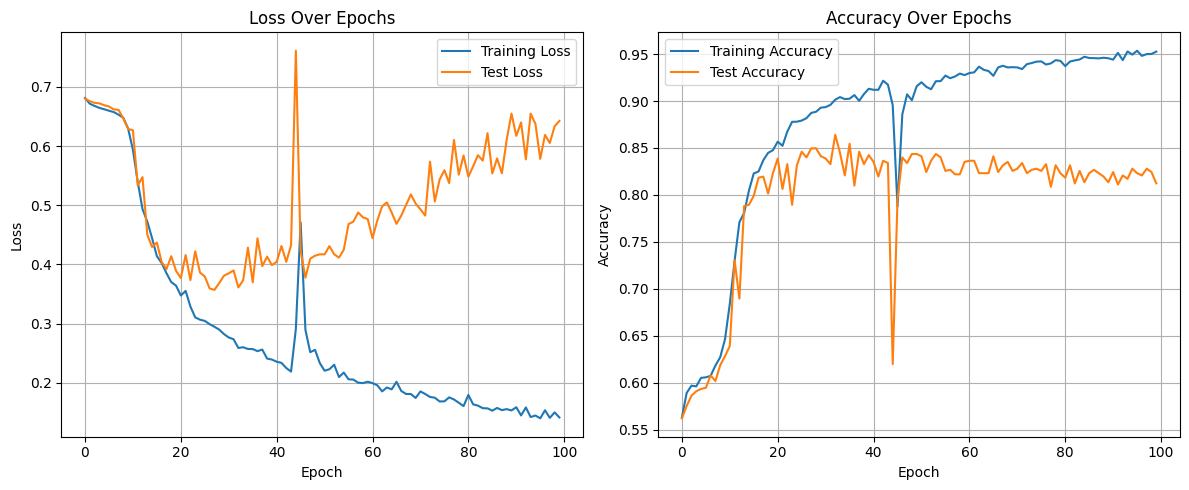

In [32]:
import matplotlib.pyplot as plt

# Plot val_loss and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot val_accuracy and accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


From this we can conclude that we should train the model for around 25 epochs or use early stopping to prevent the model from overfitting.